In [1]:
# Install all required libraries
!pip install pandas numpy nltk spacy scikit-learn gensim

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.9/27.9 MB 48.4 MB/s eta 0:00:00


In [3]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
from gensim import corpora
from gensim.models.ldamodel import LdaModel
from gensim.models.coherencemodel import CoherenceModel
import matplotlib.pyplot as plt

In [4]:
import kagglehub

# Download data
path = kagglehub.dataset_download("shashwatwork/consume-complaints-dataset-fo-nlp")

print("Path to dataset files:", path)

100%|██████████| 19.8M/19.8M [00:00<00:00, 164MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/shashwatwork/consume-complaints-dataset-fo-nlp/versions/1


In [5]:
# 1. load data

import pandas as pd

# Construct the full path to the CSV file
csv_file_path = "/root/.cache/kagglehub/datasets/shashwatwork/consume-complaints-dataset-fo-nlp/versions/1/complaints_processed.csv"

df = pd.read_csv(csv_file_path, nrows=5000)
df = df.dropna(subset=['narrative'])
print(f"Loaded {len(df)} complaints")

Loaded 4997 complaints


In [6]:
# 2. Simple preprocessing
nltk.download('stopwords')
nltk.download('punkt')
stop_words = set(stopwords.words('english'))

def clean_text(text):
    text = str(text).lower()
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # Remove punctuation and numbers
    words = text.split()
    words = [w for w in words if w not in stop_words and len(w) > 2]
    return ' '.join(words)

df['clean_text'] = df['narrative'].apply(clean_text)
print("Text cleaning completed")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


Text cleaning completed



=== FINDING OPTIMAL NUMBER OF TOPICS ===
Topics: 2, Coherence: 0.5903
Topics: 3, Coherence: 0.5878
Topics: 4, Coherence: 0.5785
Topics: 5, Coherence: 0.5380
Topics: 6, Coherence: 0.5345
Topics: 7, Coherence: 0.5612

OPTIMAL TOPICS: 2 (Coherence: 0.5903)


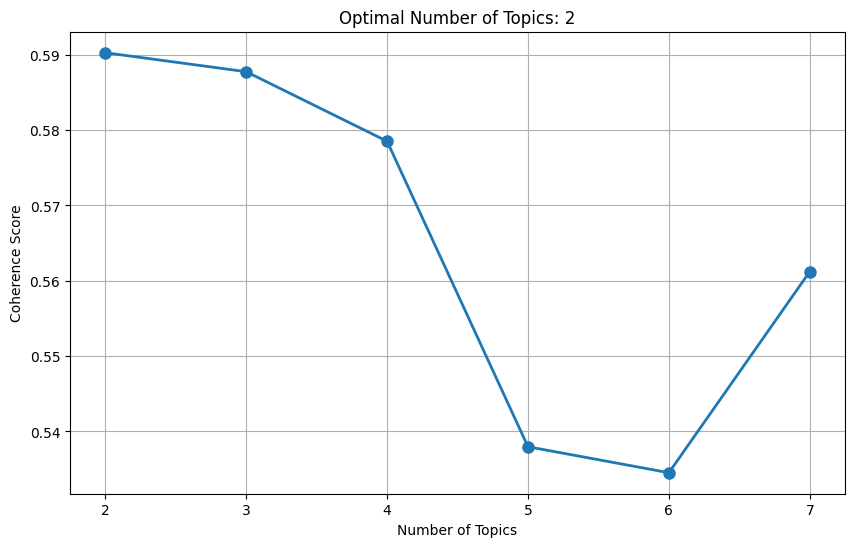

In [7]:
# 3. Prepare data for topic modeling
# Create tokens
token_lists = [text.split() for text in df['clean_text']]

# Create dictionary and corpus
dictionary = corpora.Dictionary(token_lists)
dictionary.filter_extremes(no_below=10, no_above=0.9)
corpus = [dictionary.doc2bow(tokens) for tokens in token_lists]

# 4. Find optimal number of topics using coherence scores
print("\n=== FINDING OPTIMAL NUMBER OF TOPICS ===")

coherence_scores = []
topic_range = range(2, 8)  # Test 2 to 7 topics
for num_topics in topic_range:
    lda_model = LdaModel(corpus=corpus, id2word=dictionary,
                        num_topics=num_topics, passes=10, random_state=42)

    coherence_model = CoherenceModel(model=lda_model, texts=token_lists,
                                   dictionary=dictionary, coherence='c_v')
    coherence_score = coherence_model.get_coherence()
    coherence_scores.append(coherence_score)
    print(f"Topics: {num_topics}, Coherence: {coherence_score:.4f}")

# Find best topic number
best_idx = np.argmax(coherence_scores)
optimal_topics = topic_range[best_idx]
best_coherence = coherence_scores[best_idx]
print(f"\nOPTIMAL TOPICS: {optimal_topics} (Coherence: {best_coherence:.4f})")
# Plot coherence scores
plt.figure(figsize=(10, 6))
plt.plot(topic_range, coherence_scores, marker='o', linewidth=2, markersize=8)
plt.xlabel('Number of Topics')
plt.ylabel('Coherence Score')
plt.title(f'Optimal Number of Topics: {optimal_topics}')
plt.grid(True)
plt.show()



In [8]:
# 5. Train final models with optimal topics
print(f"\n=== TRAINING MODELS WITH {optimal_topics} TOPICS ===")

# LDA Model
final_lda = LdaModel(corpus=corpus, id2word=dictionary,
                    num_topics=optimal_topics, passes=15, random_state=42)

# TF-IDF for NMF
tfidf = TfidfVectorizer(max_features=2000, min_df=5, max_df=0.9)
X_tfidf = tfidf.fit_transform(df['clean_text'])

# NMF Model
nmf = NMF(n_components=optimal_topics, random_state=42)
nmf.fit(X_tfidf)

# 6. Create topic overview
print("\n=== TOPIC OVERVIEW ===")

# Get LDA topics
print("\nLDA TOPICS:")
lda_topics = []
for i in range(optimal_topics):
    topic_words = final_lda.show_topic(i, topn=10)
    words = [word for word, score in topic_words]
    lda_topics.append(words)
    print(f"Topic {i+1}: {', '.join(words[:5])}")

# Get NMF topics
print("\nNMF TOPICS:")
feature_names = tfidf.get_feature_names_out()
nmf_topics = []
for i, topic in enumerate(nmf.components_):
    top_words_idx = topic.argsort()[-10:][::-1]
    words = [feature_names[j] for j in top_words_idx]
    nmf_topics.append(words)
    print(f"Topic {i+1}: {', '.join(words[:5])}")



=== TRAINING MODELS WITH 2 TOPICS ===

=== TOPIC OVERVIEW ===

LDA TOPICS:
Topic 1: claim, reporting, collection, debt, compliance
Topic 2: account, credit, consumer, report, information

NMF TOPICS:
Topic 1: claim, reporting, collection, compliance, plaintiff
Topic 2: report, deletion, qualified, entry, discovered


In [9]:
# 7. Compare topics side by side
print("\n=== TOPIC COMPARISON ===")
print("LDA vs NMF Topics:")
print("-" * 60)
for i in range(optimal_topics):
    print(f"TOPIC {i+1}:")
    print(f"  LDA: {', '.join(lda_topics[i][:5])}")
    print(f"  NMF: {', '.join(nmf_topics[i][:5])}")
    print()

# 8. Calculate final coherence score
coherence_model_final = CoherenceModel(model=final_lda, texts=token_lists,
                                     dictionary=dictionary, coherence='c_v')
final_coherence = coherence_model_final.get_coherence()
print(f"\nFINAL COHERENCE SCORE: {final_coherence:.4f}")


=== TOPIC COMPARISON ===
LDA vs NMF Topics:
------------------------------------------------------------
TOPIC 1:
  LDA: claim, reporting, collection, debt, compliance
  NMF: claim, reporting, collection, compliance, plaintiff

TOPIC 2:
  LDA: account, credit, consumer, report, information
  NMF: report, deletion, qualified, entry, discovered


FINAL COHERENCE SCORE: 0.5815


In [10]:
# 9. Save results to files
# Save topic keywords
with open('topic_keywords.txt', 'w') as f:
    f.write(f"Optimal Topics: {optimal_topics}\n")
    f.write(f"Coherence Score: {final_coherence:.4f}\n\n")

    f.write("LDA TOPICS:\n")
    for i, topic in enumerate(lda_topics):
        f.write(f"Topic {i+1}: {', '.join(topic[:8])}\n")

    f.write("\nNMF TOPICS:\n")
    for i, topic in enumerate(nmf_topics):
        f.write(f"Topic {i+1}: {', '.join(topic[:8])}\n")

print("\nTopic keywords saved to 'topic_keywords.txt'")

# 10. Simple visualization of topic distribution
print("\n=== TOPIC DISTRIBUTION ===")

# Count documents per topic (LDA)
topic_counts = [0] * optimal_topics
for doc in corpus:
    topic_probs = final_lda.get_document_topics(doc)
    if topic_probs:
        main_topic = max(topic_probs, key=lambda x: x[1])[0]
        topic_counts[main_topic] += 1

# Print distribution
for i in range(optimal_topics):
    percentage = (topic_counts[i] / len(corpus)) * 100
    print(f"Topic {i+1}: {topic_counts[i]} documents ({percentage:.1f}%)")

print("\n=== ANALYSIS COMPLETE ===")
print(f"Summary: Found {optimal_topics} optimal topics with coherence {final_coherence:.4f}")


Topic keywords saved to 'topic_keywords.txt'

=== TOPIC DISTRIBUTION ===
Topic 1: 470 documents (9.4%)
Topic 2: 4527 documents (90.6%)

=== ANALYSIS COMPLETE ===
Summary: Found 2 optimal topics with coherence 0.5815
